In [1]:
import logging
from dataclasses import dataclass
from astropy import units as u
from matplotlib import pyplot as plt
import numpy as np
from diskchef.physics.williams_best import WB100auWithSmoothInnerGap
from diskchef import RadMCRTLines, Line, SciKitChemistry, logging_basic_config
from diskchef.maps.radmc_lines import RadMCRTLinesTraceTau, RadMCRTLinesTauSurf
from spectral_cube import SpectralCube

logging_basic_config(level=logging.INFO)
import plotly.graph_objects as go
from astropy.coordinates import CartesianRepresentation
from astropy.coordinates.matrix_utilities import rotation_matrix


def plot_3d(coords, name='plotly'):
    layout = go.Layout(
        scene=dict(
            aspectmode='data'
        ))

    fig = go.Figure(data=[
        go.Scatter3d(x=coords.x.value, y=coords.y.value, z=coords.z.value, mode='markers', marker={'size': 2}),
        go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', marker={'size': 5, 'color': 'red'}),
    ],
        layout=layout
    )
    fig.update_yaxes(
        scaleanchor="x",
        scaleratio=1,
    )
    fig.write_html(f"{name}.html")
    fig.show()


def runtausurf(bins, incl, posang, name):
    physics = WB100auWithSmoothInnerGap(star_mass=0.52 * u.solMass, radial_bins=bins, vertical_bins=bins,
                                        atmosphere_temperature_100au=40 * u.K, inner_radius=5 * u.au, r_min=5 * u.au)
    plt.figure()
    physics.plot_density()
    plt.figure()
    physics.plot_temperatures();
    chemistry = SciKitChemistry(physics=physics)
    chemistry.run_chemistry()
    chemistry.table["CO"][chemistry.table.zr < 0.15] = 1e-100
    chemistry.table["13CO"] = chemistry.table["CO"] / 70
    plt.figure()
    chemistry.plot_absolute_chemistry("CO", "13CO");
    rttau1 = RadMCRTLinesTauSurf(
        chemistry=chemistry,
        line_list=[
            Line(name='CO J=3-2', transition=3, molecule='CO'),
            Line(name='13CO J=3-2', transition=3, molecule='13CO')
        ],
        folder=name, tau=1,
        # radii_bins=1000, theta_bins=1000,
        # coordinate="DQ Tau"
    )
    rttau1.create_files(channels_per_line=103, window_width=5 * u.km / u.s)
    rttau1.run(inclination=incl * u.deg, position_angle=posang * u.deg, distance=128 * u.pc, npix=100)
    rttau1.channel_maps()
    for line, output in rttau1.outputs.items():
        print(line, output)
        file = output.file_fits
        print(file)
        cube = SpectralCube.read(file)
        display(cube)
        display(cube.header)
        distance = output.distance
        display(distance)

        cube = cube.with_spectral_unit(u.km / u.s, velocity_convention="radio")
        pixscale = (cube.wcs.celestial.proj_plane_pixel_area() ** 0.5 * distance).to(u.au, u.dimensionless_angles())
        vscale = cube.wcs.pixel_scale_matrix[-1, -1] * u.Unit(cube.wcs.world_axis_units[-1])
        x_grid = (np.arange(cube.wcs.celestial.pixel_shape[0]) - cube.wcs.celestial.pixel_shape[0] / 2 + 0.5) * pixscale
        y_grid = (np.arange(cube.wcs.celestial.pixel_shape[1]) - cube.wcs.celestial.pixel_shape[1] / 2 + 0.5) * pixscale
        v_grid = (np.arange(cube.wcs.pixel_shape[-1]) - cube.wcs.celestial.pixel_shape[-1] / 2 + 0.5) * vscale
        x, y, v = np.meshgrid(x_grid, y_grid, v_grid)
        z = np.swapaxes(cube.filled_data[:].to(u.au), 0, -1)

        mask = (np.abs(z) < x.max())
        xpl = x[mask].flatten()
        ypl = y[mask].flatten()
        zpl = z[mask].flatten()
        vpl = v[mask].flatten()

        inclination = incl * u.deg
        position_angle = posang * u.deg

        rotation_posang = rotation_matrix(-position_angle, axis='z')
        rotation_incl = rotation_matrix(inclination, axis='x')
        coords = CartesianRepresentation(x=xpl, y=ypl, z=zpl)
        coords_posang_incl = coords.transform(rotation_posang).transform(rotation_incl)

        r = (coords_posang_incl.x ** 2 + coords_posang_incl.y ** 2) ** 0.5
        zr = coords_posang_incl.z / r

        scatter_kw = dict(s=10, c=vpl, cmap="coolwarm", edgecolors='k', linewidths=0.1)
        fig, ax = plt.subplots(2, 2, figsize=(15, 10))

        physics.plot_density(axes=ax[0, 0])
        ax[0, 0].autoscale(enable=False)
        ax[0, 0].scatter(r, zr, **scatter_kw)
        physics.plot_temperatures(axes=ax[1, 0])
        ax[1, 0].autoscale(enable=False)
        ax[1, 0].scatter(r, zr, **scatter_kw)
        chemistry.plot_chemistry("CO", "13CO", axes=ax[0, 1])
        ax[0, 1].autoscale(enable=False)
        ax[0, 1].scatter(r, zr, **scatter_kw)
        chemistry.plot_absolute_chemistry("CO", "13CO", axes=ax[1, 1])
        ax[1, 1].autoscale(enable=False)
        ax[1, 1].scatter(r, zr, **scatter_kw)
        fig.savefig(name + ".pdf")
        plot_3d(coords_posang_incl, name + "_" + line.name)
        plot_3d(coords, name + "_" + line.name + "_unprojected")

07.04.2022 10:41:51 ( 231773073 ms) PID       1931  diskchef.physics.base.WB100auWithSmoothInnerGap              INFO     Creating an instance of WB100auWithSmoothInnerGap
07.04.2022 10:41:53 ( 231774534 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:41:56 ( 231778394 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:42:00 ( 231782211 ms) PID       1931  diskchef.chemistry.base.SciKitChemistry                      INFO     Creating an instance of SciKitChemistry
07.04.2022 10:42:00 ( 231782218 ms) PID       1931  py.warnings                                                  WARNING  /home/smirnov/anaconda3/envs/latest/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning:

Trying to unpickle estimator QuantileTransformer from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid 

Line(name='13CO J=3-2', transition=3, molecule='13CO', collision_partner=('H2',), lamda_file='/mnt/d/astrowork/diskchef/diskchef/lamda/files/13co.dat') RadMCOutput(line=Line(name='13CO J=3-2', transition=3, molecule='13CO', collision_partner=('H2',), lamda_file='/mnt/d/astrowork/diskchef/diskchef/lamda/files/13co.dat'), file_radmc='radmc_tau1_89_0/13CO J=3-2_image.out', file_fits='radmc_tau1_89_0/13CO J=3-2_image_tau_ 1.00e+00.fits', object_name='', distance=<Quantity 128. pc>, cloud=None, mode='tausurf')
radmc_tau1_89_0/13CO J=3-2_image_tau_ 1.00e+00.fits


SpectralCube with shape=(103, 100, 100) and unit=AU:
 n_x:    100  type_x: RA---TAN  unit_x: deg    range:     0.001206 deg:  359.998842 deg
 n_y:    100  type_y: DEC--TAN  unit_y: deg    range:    -0.001182 deg:    0.001182 deg
 n_s:    103  type_s: FREQ      unit_s: Hz     range: 330585208414.973 Hz:330590722026.007 Hz

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3                                                  
NAXIS1  =                  100                                                  
NAXIS2  =                  100                                                  
NAXIS3  =                  103                                                  
RESTFREQ=       330587965221.8                                                  
BUNIT   = 'AU      '                                                            
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                 51.0 / Pixel coordinate of reference point            
CRPIX2  =                 51.0 / Pixel coordinate of reference point            
CRPIX3  =                 52.0 / Pixel coordinate of reference point            
CDELT1  = -2.3871528183479E-

<Quantity 128. pc>

07.04.2022 10:42:34 ( 231815828 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:42:37 ( 231819286 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:42:39 ( 231820738 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:42:39 ( 231821038 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D


Line(name='CO J=3-2', transition=3, molecule='CO', collision_partner=('H2',), lamda_file='/mnt/d/astrowork/diskchef/diskchef/lamda/files/co.dat') RadMCOutput(line=Line(name='CO J=3-2', transition=3, molecule='CO', collision_partner=('H2',), lamda_file='/mnt/d/astrowork/diskchef/diskchef/lamda/files/co.dat'), file_radmc='radmc_tau1_89_0/CO J=3-2_image.out', file_fits='radmc_tau1_89_0/CO J=3-2_image_tau_ 1.00e+00.fits', object_name='', distance=<Quantity 128. pc>, cloud=None, mode='tausurf')
radmc_tau1_89_0/CO J=3-2_image_tau_ 1.00e+00.fits


SpectralCube with shape=(103, 100, 100) and unit=AU:
 n_x:    100  type_x: RA---TAN  unit_x: deg    range:     0.001206 deg:  359.998842 deg
 n_y:    100  type_y: DEC--TAN  unit_y: deg    range:    -0.001182 deg:    0.001182 deg
 n_s:    103  type_s: FREQ      unit_s: Hz     range: 345793106274.279 Hz:345798873529.541 Hz

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3                                                  
NAXIS1  =                  100                                                  
NAXIS2  =                  100                                                  
NAXIS3  =                  103                                                  
RESTFREQ=       345795989900.0                                                  
BUNIT   = 'AU      '                                                            
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                 51.0 / Pixel coordinate of reference point            
CRPIX2  =                 51.0 / Pixel coordinate of reference point            
CRPIX3  =                 52.0 / Pixel coordinate of reference point            
CDELT1  = -2.3871528183479E-

<Quantity 128. pc>

07.04.2022 10:42:41 ( 231823109 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:42:45 ( 231826920 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:42:46 ( 231828308 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:42:47 ( 231828603 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D


07.04.2022 10:42:53 ( 231835128 ms) PID       1931  diskchef.physics.base.WB100auWithSmoothInnerGap              INFO     Creating an instance of WB100auWithSmoothInnerGap
07.04.2022 10:42:55 ( 231836671 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:42:58 ( 231840378 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:43:00 ( 231841997 ms) PID       1931  diskchef.chemistry.base.SciKitChemistry                      INFO     Creating an instance of SciKitChemistry
07.04.2022 10:43:00 ( 231842004 ms) PID       1931  py.warnings                                                  WARNING  /home/smirnov/anaconda3/envs/latest/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning:

Trying to unpickle estimator QuantileTransformer from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid 

Line(name='13CO J=3-2', transition=3, molecule='13CO', collision_partner=('H2',), lamda_file='/mnt/d/astrowork/diskchef/diskchef/lamda/files/13co.dat') RadMCOutput(line=Line(name='13CO J=3-2', transition=3, molecule='13CO', collision_partner=('H2',), lamda_file='/mnt/d/astrowork/diskchef/diskchef/lamda/files/13co.dat'), file_radmc='radmc_tau1_89_30/13CO J=3-2_image.out', file_fits='radmc_tau1_89_30/13CO J=3-2_image_tau_ 1.00e+00.fits', object_name='', distance=<Quantity 128. pc>, cloud=None, mode='tausurf')
radmc_tau1_89_30/13CO J=3-2_image_tau_ 1.00e+00.fits


SpectralCube with shape=(103, 100, 100) and unit=AU:
 n_x:    100  type_x: RA---TAN  unit_x: deg    range:     0.001206 deg:  359.998842 deg
 n_y:    100  type_y: DEC--TAN  unit_y: deg    range:    -0.001182 deg:    0.001182 deg
 n_s:    103  type_s: FREQ      unit_s: Hz     range: 330585208414.973 Hz:330590722026.007 Hz

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3                                                  
NAXIS1  =                  100                                                  
NAXIS2  =                  100                                                  
NAXIS3  =                  103                                                  
RESTFREQ=       330587965221.8                                                  
BUNIT   = 'AU      '                                                            
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                 51.0 / Pixel coordinate of reference point            
CRPIX2  =                 51.0 / Pixel coordinate of reference point            
CRPIX3  =                 52.0 / Pixel coordinate of reference point            
CDELT1  = -2.3871528183479E-

<Quantity 128. pc>

07.04.2022 10:43:37 ( 231878501 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:43:41 ( 231882471 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:43:42 ( 231884441 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:43:43 ( 231884798 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D


Line(name='CO J=3-2', transition=3, molecule='CO', collision_partner=('H2',), lamda_file='/mnt/d/astrowork/diskchef/diskchef/lamda/files/co.dat') RadMCOutput(line=Line(name='CO J=3-2', transition=3, molecule='CO', collision_partner=('H2',), lamda_file='/mnt/d/astrowork/diskchef/diskchef/lamda/files/co.dat'), file_radmc='radmc_tau1_89_30/CO J=3-2_image.out', file_fits='radmc_tau1_89_30/CO J=3-2_image_tau_ 1.00e+00.fits', object_name='', distance=<Quantity 128. pc>, cloud=None, mode='tausurf')
radmc_tau1_89_30/CO J=3-2_image_tau_ 1.00e+00.fits


SpectralCube with shape=(103, 100, 100) and unit=AU:
 n_x:    100  type_x: RA---TAN  unit_x: deg    range:     0.001206 deg:  359.998842 deg
 n_y:    100  type_y: DEC--TAN  unit_y: deg    range:    -0.001182 deg:    0.001182 deg
 n_s:    103  type_s: FREQ      unit_s: Hz     range: 345793106274.279 Hz:345798873529.541 Hz

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3                                                  
NAXIS1  =                  100                                                  
NAXIS2  =                  100                                                  
NAXIS3  =                  103                                                  
RESTFREQ=       345795989900.0                                                  
BUNIT   = 'AU      '                                                            
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                 51.0 / Pixel coordinate of reference point            
CRPIX2  =                 51.0 / Pixel coordinate of reference point            
CRPIX3  =                 52.0 / Pixel coordinate of reference point            
CDELT1  = -2.3871528183479E-

<Quantity 128. pc>

07.04.2022 10:43:45 ( 231887067 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:43:49 ( 231891154 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:43:51 ( 231892740 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:43:51 ( 231893069 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D


07.04.2022 10:43:55 ( 231896930 ms) PID       1931  diskchef.physics.base.WB100auWithSmoothInnerGap              INFO     Creating an instance of WB100auWithSmoothInnerGap
07.04.2022 10:43:57 ( 231898581 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:44:01 ( 231902713 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:44:02 ( 231904418 ms) PID       1931  diskchef.chemistry.base.SciKitChemistry                      INFO     Creating an instance of SciKitChemistry
07.04.2022 10:44:02 ( 231904428 ms) PID       1931  py.warnings                                                  WARNING  /home/smirnov/anaconda3/envs/latest/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning:

Trying to unpickle estimator QuantileTransformer from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid 

Line(name='13CO J=3-2', transition=3, molecule='13CO', collision_partner=('H2',), lamda_file='/mnt/d/astrowork/diskchef/diskchef/lamda/files/13co.dat') RadMCOutput(line=Line(name='13CO J=3-2', transition=3, molecule='13CO', collision_partner=('H2',), lamda_file='/mnt/d/astrowork/diskchef/diskchef/lamda/files/13co.dat'), file_radmc='radmc_tau1_89_90/13CO J=3-2_image.out', file_fits='radmc_tau1_89_90/13CO J=3-2_image_tau_ 1.00e+00.fits', object_name='', distance=<Quantity 128. pc>, cloud=None, mode='tausurf')
radmc_tau1_89_90/13CO J=3-2_image_tau_ 1.00e+00.fits


SpectralCube with shape=(103, 100, 100) and unit=AU:
 n_x:    100  type_x: RA---TAN  unit_x: deg    range:     0.001206 deg:  359.998842 deg
 n_y:    100  type_y: DEC--TAN  unit_y: deg    range:    -0.001182 deg:    0.001182 deg
 n_s:    103  type_s: FREQ      unit_s: Hz     range: 330585208414.973 Hz:330590722026.007 Hz

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3                                                  
NAXIS1  =                  100                                                  
NAXIS2  =                  100                                                  
NAXIS3  =                  103                                                  
RESTFREQ=       330587965221.8                                                  
BUNIT   = 'AU      '                                                            
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                 51.0 / Pixel coordinate of reference point            
CRPIX2  =                 51.0 / Pixel coordinate of reference point            
CRPIX3  =                 52.0 / Pixel coordinate of reference point            
CDELT1  = -2.3871528183479E-

<Quantity 128. pc>

07.04.2022 10:45:13 ( 231974680 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:45:17 ( 231978599 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:45:18 ( 231980149 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:45:19 ( 231980460 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D


Line(name='CO J=3-2', transition=3, molecule='CO', collision_partner=('H2',), lamda_file='/mnt/d/astrowork/diskchef/diskchef/lamda/files/co.dat') RadMCOutput(line=Line(name='CO J=3-2', transition=3, molecule='CO', collision_partner=('H2',), lamda_file='/mnt/d/astrowork/diskchef/diskchef/lamda/files/co.dat'), file_radmc='radmc_tau1_89_90/CO J=3-2_image.out', file_fits='radmc_tau1_89_90/CO J=3-2_image_tau_ 1.00e+00.fits', object_name='', distance=<Quantity 128. pc>, cloud=None, mode='tausurf')
radmc_tau1_89_90/CO J=3-2_image_tau_ 1.00e+00.fits


SpectralCube with shape=(103, 100, 100) and unit=AU:
 n_x:    100  type_x: RA---TAN  unit_x: deg    range:     0.001206 deg:  359.998842 deg
 n_y:    100  type_y: DEC--TAN  unit_y: deg    range:    -0.001182 deg:    0.001182 deg
 n_s:    103  type_s: FREQ      unit_s: Hz     range: 345793106274.279 Hz:345798873529.541 Hz

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3                                                  
NAXIS1  =                  100                                                  
NAXIS2  =                  100                                                  
NAXIS3  =                  103                                                  
RESTFREQ=       345795989900.0                                                  
BUNIT   = 'AU      '                                                            
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                 51.0 / Pixel coordinate of reference point            
CRPIX2  =                 51.0 / Pixel coordinate of reference point            
CRPIX3  =                 52.0 / Pixel coordinate of reference point            
CDELT1  = -2.3871528183479E-

<Quantity 128. pc>

07.04.2022 10:45:21 ( 231982794 ms) PID       1931  py.warnings                                                  WARNING  <ipython-input-1-a657ab28cf04>:100: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


07.04.2022 10:45:21 ( 231983021 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:45:26 ( 231987676 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:45:27 ( 231989294 ms) PID       1931  diskchef.engine.plot.Plot2D                                  INFO     Creating an instance of Plot2D
07.04.2022 10:45:28 ( 231989613 ms) PID       1931  diskchef.engine.plot.Plot2D                                

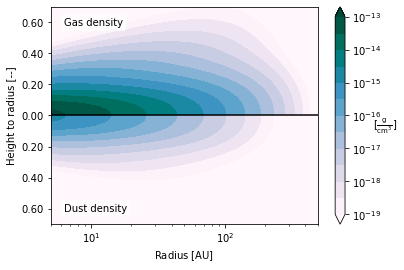

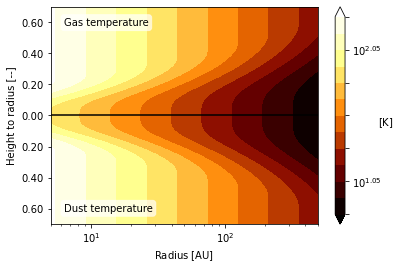

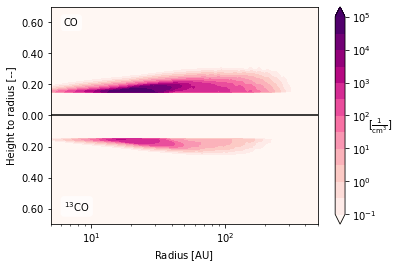

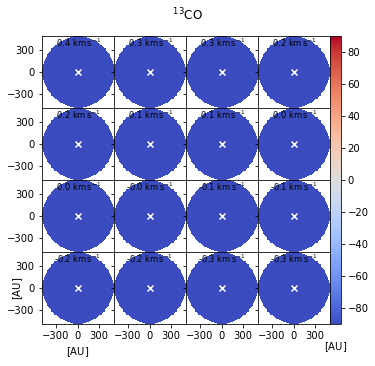

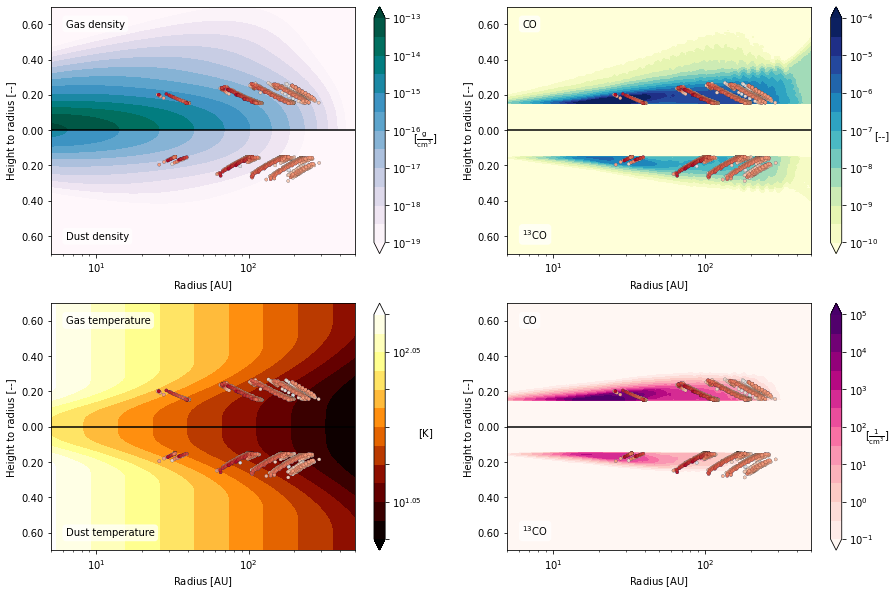

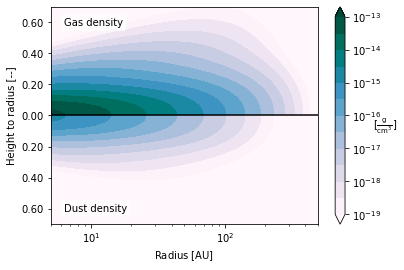

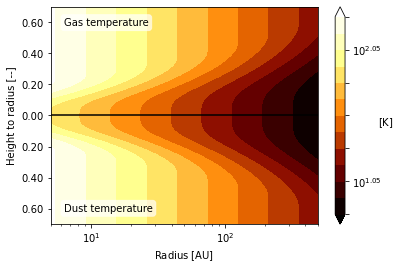

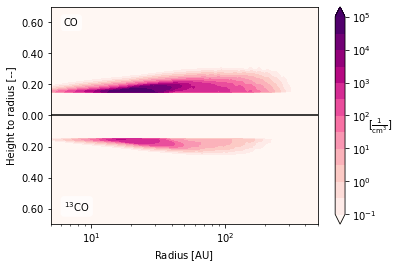

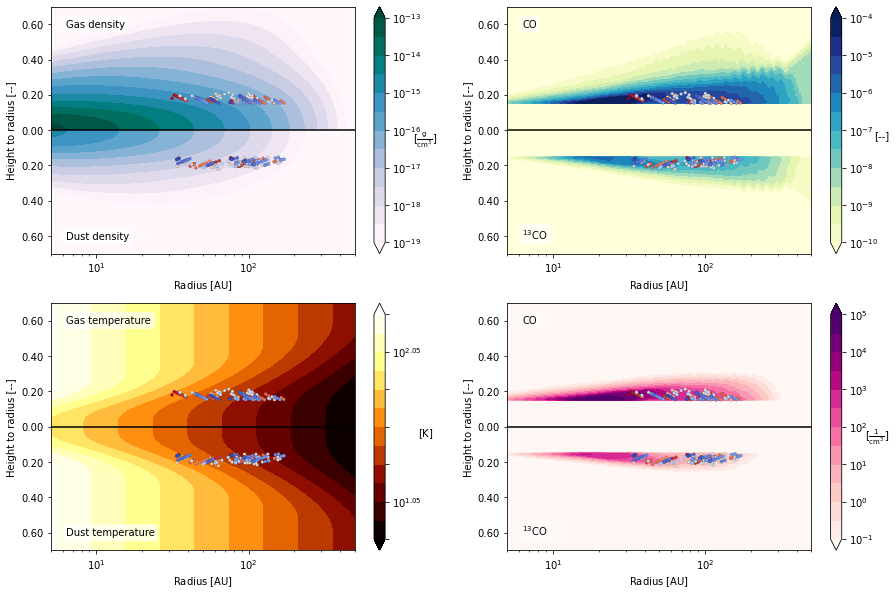

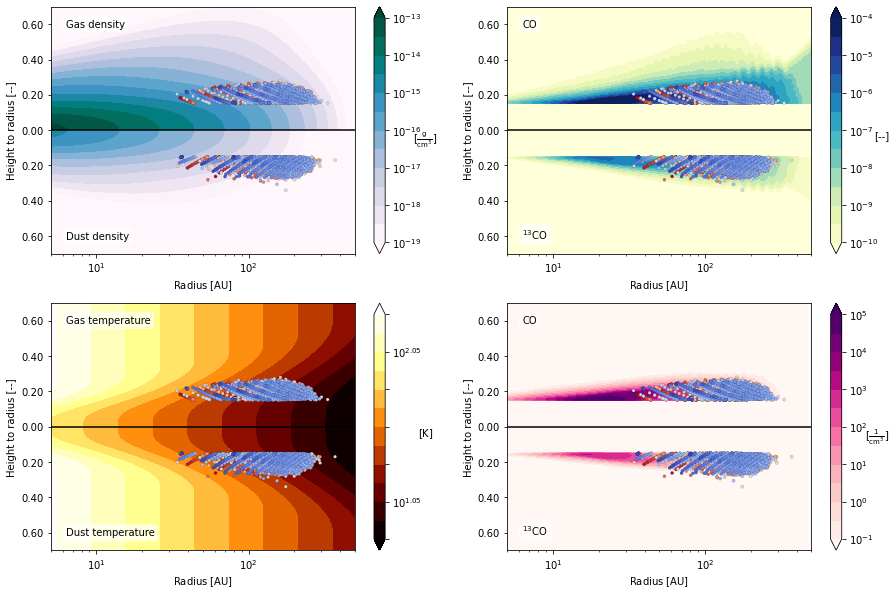

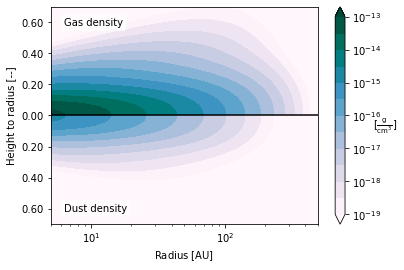

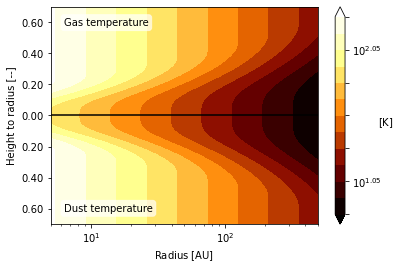

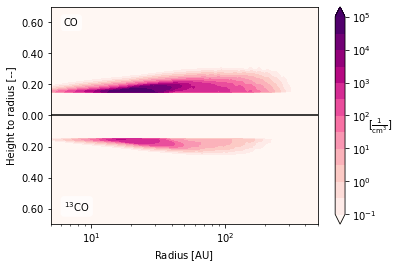

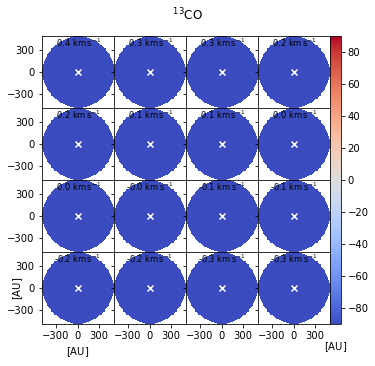

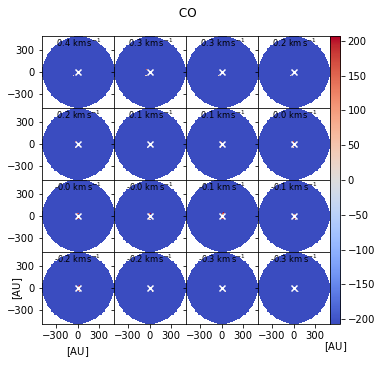

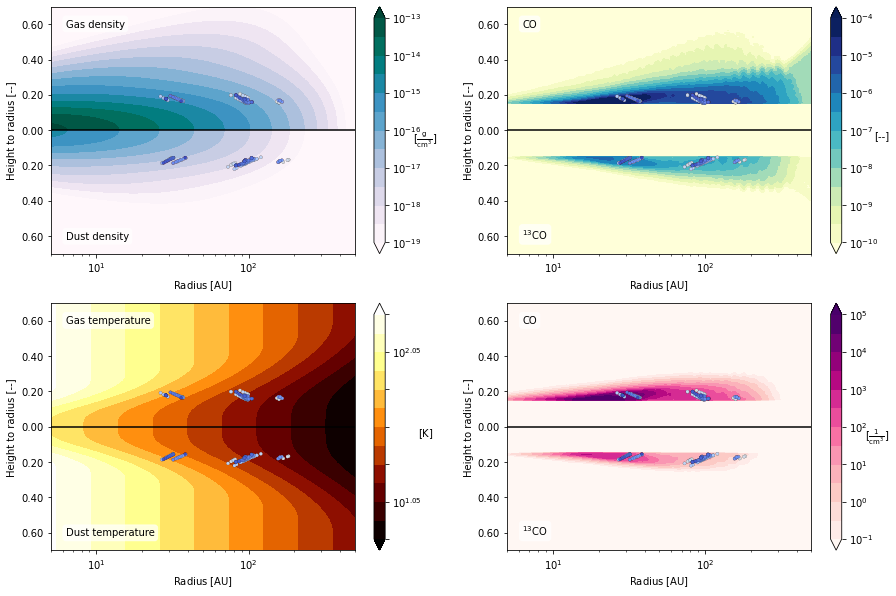

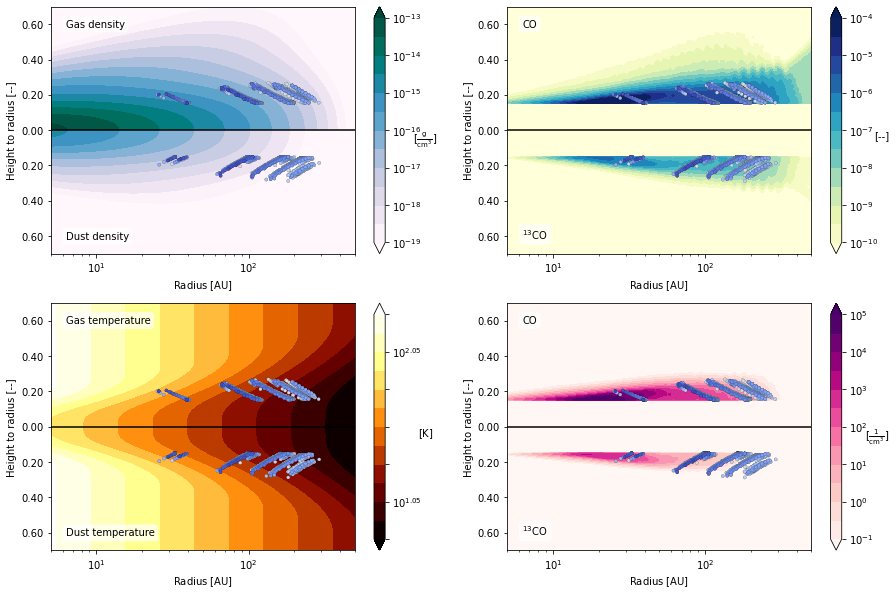

In [7]:
bins = 100
incl = 45
posang = 0

# for incl in (0, 90, 30, 45, 1, 10):
for incl in (89,):
    for posang in (0, 30, 90):
        name = f"radmc_tau1_{incl}_{posang}"
        runtausurf(bins, incl, posang, name)